# Tarea 3: PINNs, Redes Recurrentes y Transformers

En esta Tarea Trabajaremos Con [Pytorch](https://pytorch.org/), una librería de Deep Learning de código abierto desarrollada por Facebook. Pytorch es una librería de Deep Learning que se basa en el concepto de [Tensores](https://pytorch.org/docs/stable/tensors.html), que son similares a los arreglos de Numpy, pero con la diferencia de que pueden ser utilizados en una GPU para acelerar los cálculos.

Se escogio Pytorch por sobre Tensorflow o Keras ya que tiene un paquete de [diferenciacion automatica](https://pytorch.org/docs/stable/autograd.html) que nos permite calcular derivadas de forma automatica, lo que nos permite implementar de forma sencilla los modelos de redes neuronales y sobre todo trabajar con PINNs y modificar pequeños detalles de forma sencilla en el lopp de entrenamiento como lo es aplicar custom losses, etc.

Dado que la ultima seccion del curso esta enfocado a trabajar con series temporales, todos los problemas en esta tarea de alguna u otra forma estan relacionados con series temporales o secuencias.

# 1. Imports

In [ ]:
#data
import numpy as np
import pandas  as pd

# torch
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(123)

En esta tarea tenemos 2 Secciones obligatorias, la parte de Redes Recurrentes y la Parte de Transformers, pero como no hay desafio Kaggle se añadio una seccion extra sobre PINNS (Physics Informed Neural Networks) la cual es opcional y sirve como bonus para la nota final.

Dado que no hay desafio Kaggle se incentiva a ser creativos y modificar los codigos, esto tambien añadira un bonus para la tarea.

# Parte 2: Redes Recurrentes

En esta tarea no hay desafio kaggle, por lo que en esta seccion deberan utilizar su creatividad para resolver un problema de series temporales, utilizando redes recurrentes.

## 2.1 Cargar Datos

In [ ]:
import pandas  as pd

train_path = '/content/DailyClimate_Train.csv'
test_path= '/content/DailyClimate_test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

## 2.2 EDA & data Viz

En esta seccion deberan realizar un analisis exploratorio de los datos, generar visualizaciones que les permitan entender mejor los datos con los que estan trabajando y sacar conclusiones de estos.

In [ ]:
### Start code here ###
train_df = train_df.info()
'''
Vemos que no hay valores nulos en el dataset
date: Fecha de la observación
meantemp: La temperatura media del día.
humidity: La humedad media del día.
wind_speed: La velocidad media del viento del día.
meanpressure: La presión media del día.

No hay columnas de datos que se vean inutiles o que no aporten información, al menos
a primera vista.
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   meantemp         114 non-null    float64
 1   humidity         114 non-null    float64
 2   wind_speed       114 non-null    float64
 3   meanpressure     114 non-null    float64
 4   day_of_year_sin  114 non-null    float64
 5   day_of_year_cos  114 non-null    float64
dtypes: float64(6)
memory usage: 5.5 KB


'\nVemos que no hay valores nulos en el dataset\ndate: Fecha de la observación\nmeantemp: La temperatura media del día.\nhumidity: La humedad media del día.\nwind_speed: La velocidad media del viento del día.\nmeanpressure: La presión media del día.\n\nNo hay columnas de datos que se vean inutiles o que no aporten información, al menos\na primera vista.\n'

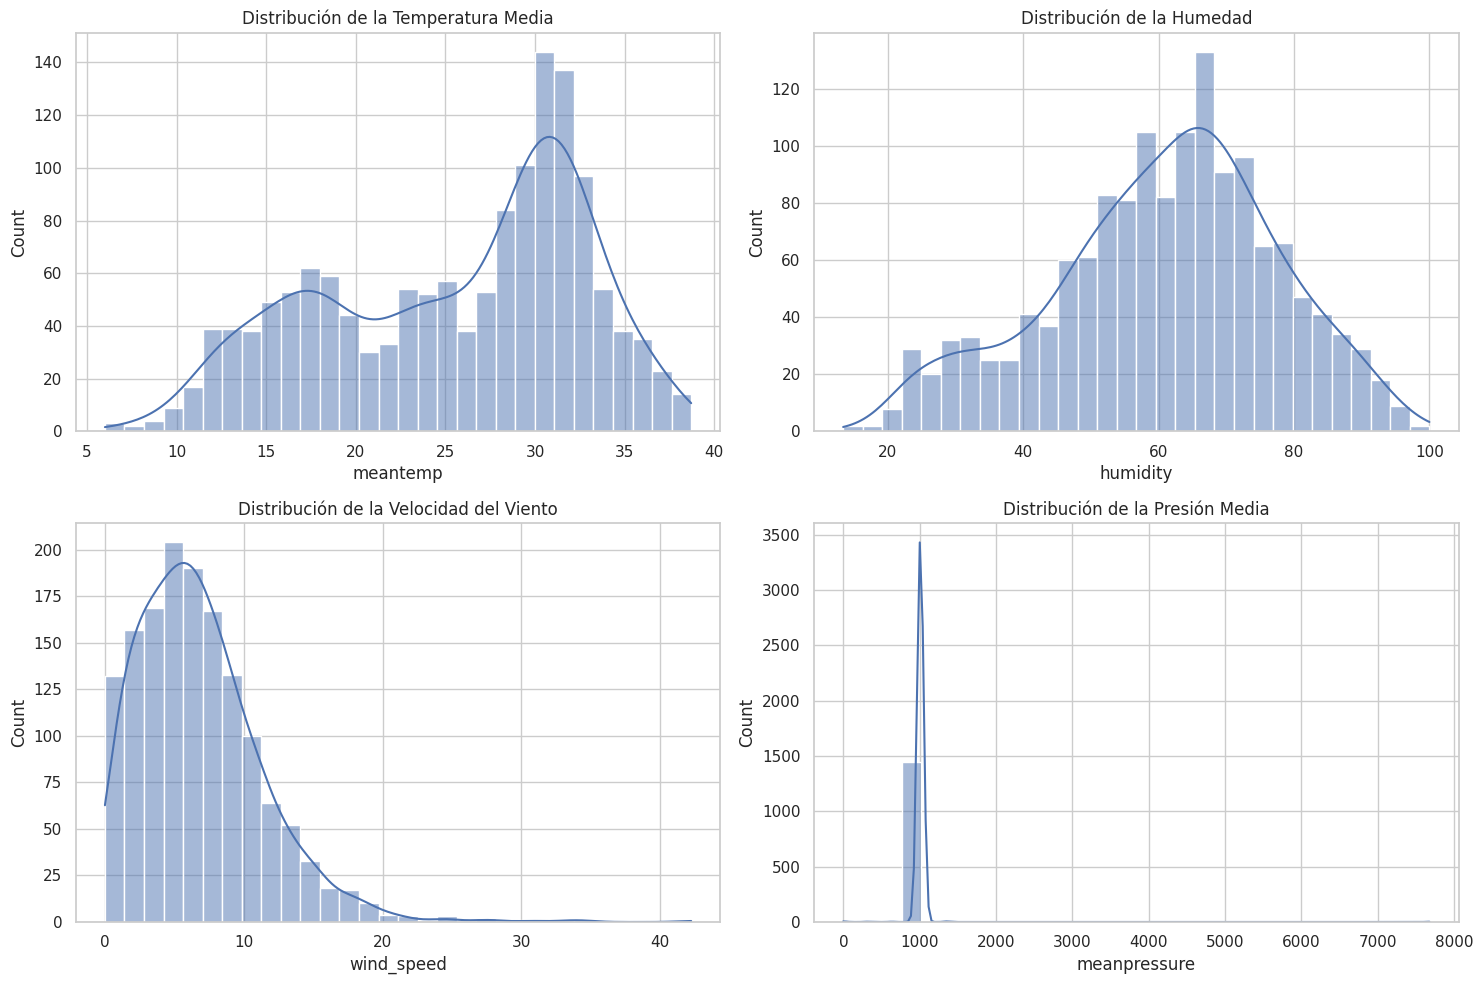

In [ ]:
#Histograma de las Distribuciones de las variables

climate_data = pd.read_csv(train_path)
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
sns.histplot(climate_data['meantemp'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribución de la Temperatura Media')
sns.histplot(climate_data['humidity'], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribución de la Humedad')
sns.histplot(climate_data['wind_speed'], bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribución de la Velocidad del Viento')
sns.histplot(climate_data['meanpressure'], bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribución de la Presión Media')
plt.tight_layout()
plt.show()

- **Temperatura Media**: La distribución de la temperatura media parece ser bimodal, indicando dos modas en las temperaturas a lo largo del año.
- **Humedad**: La distribución de la humedad es relativamente uniforme, aunque con una ligera inclinación hacia valores más bajos.
- **Velocidad del Viento**: La mayoría de las observaciones de velocidad del viento están agrupadas en el extremo inferior, con algunos valores atípicos extendiéndose hacia valores más altos.
- **Presión Media**: La distribución de la presión media muestra una clara anomalía. La mayoría de los valores están en un rango razonable, pero hay un pico extremadamente alto cerca de x=1000, lo que sugiere valores atípicos o errores en los datos.

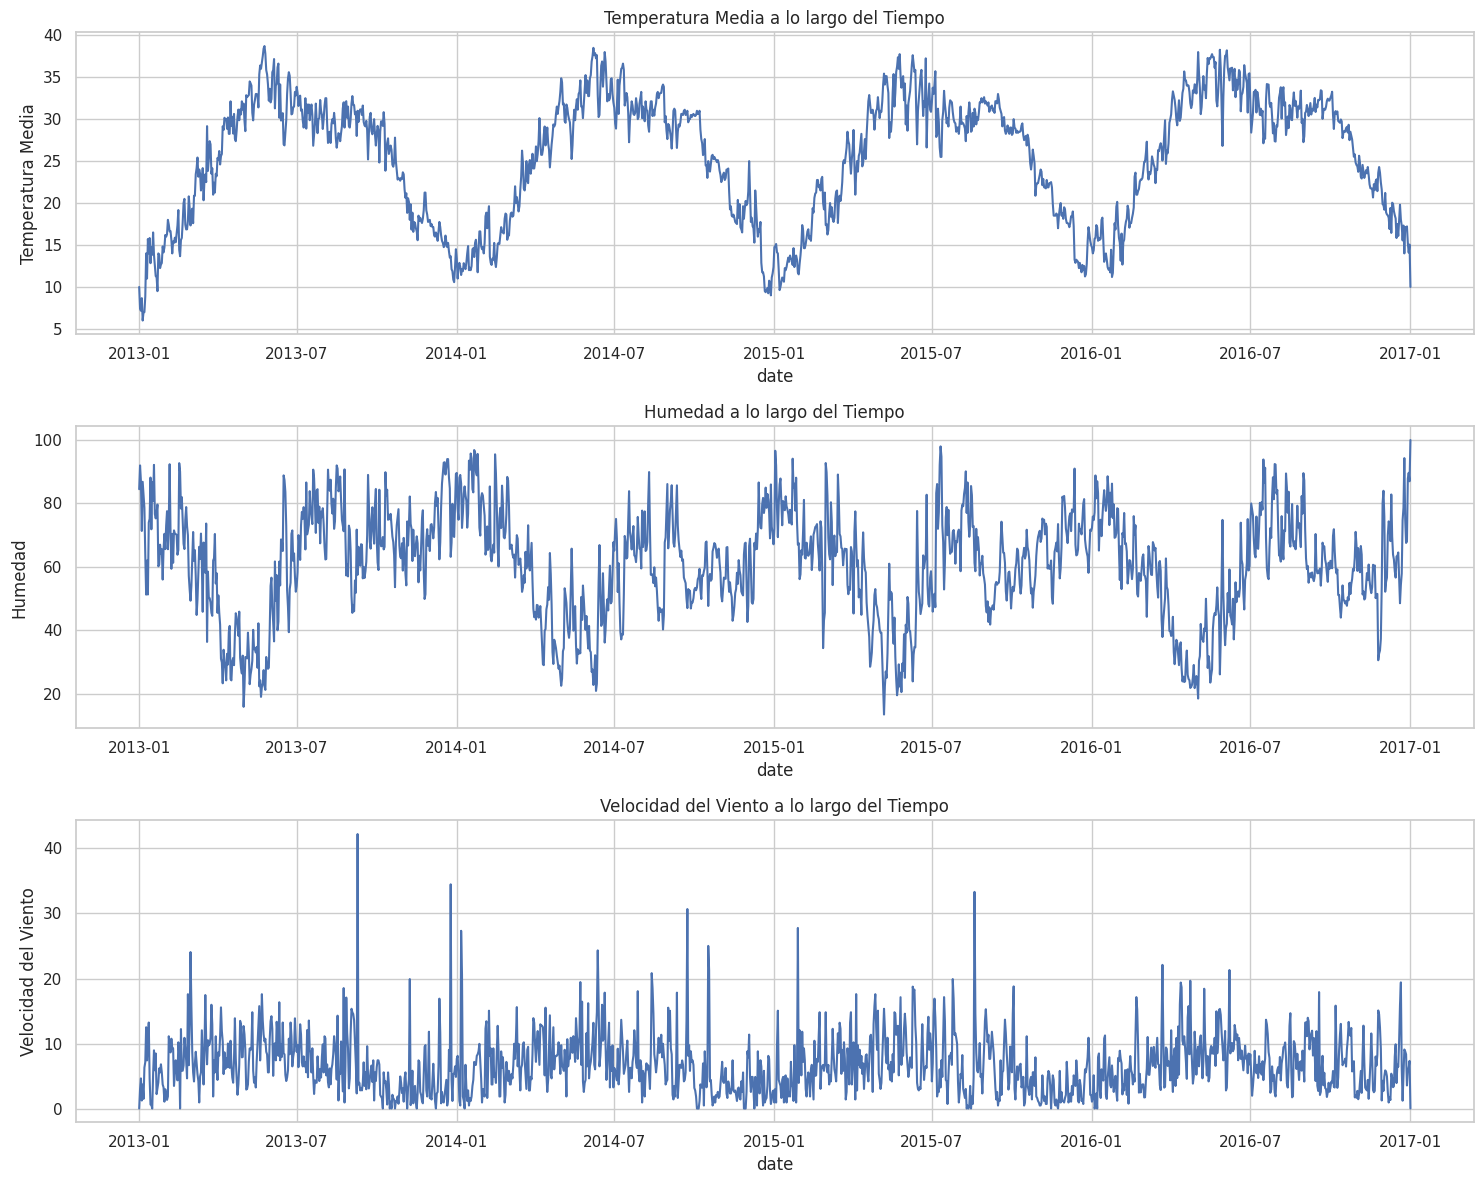

In [ ]:
climate_data['date'] = pd.to_datetime(climate_data['date'])
fig, axes = plt.subplots(nrows=3, figsize=(15, 12))
sns.lineplot(x='date', y='meantemp', data=climate_data, ax=axes[0])
axes[0].set_title('Temperatura Media a lo largo del Tiempo')
axes[0].set_ylabel('Temperatura Media')
sns.lineplot(x='date', y='humidity', data=climate_data, ax=axes[1])
axes[1].set_title('Humedad a lo largo del Tiempo')
axes[1].set_ylabel('Humedad')
sns.lineplot(x='date', y='wind_speed', data=climate_data, ax=axes[2])
axes[2].set_title('Velocidad del Viento a lo largo del Tiempo')
axes[2].set_ylabel('Velocidad del Viento')

plt.tight_layout()
plt.show()


- **Temperatura Media** : Se observa una clara estacionalidad en la temperatura, con picos y valles que probablemente correspondan a los cambios de estación a lo largo del año. Esto indica variaciones normales de temperatura con las estaciones.

- **Humedad** : También hay cierta estacionalidad en la humedad, aunque menos pronunciada que en la temperatura. La humedad parece fluctuar a lo largo del año, con algunos períodos de mayor y menor humedad.

- **Velocidad del Viento** : La velocidad del viento muestra fluctuaciones a lo largo del tiempo, con algunos picos que pueden representar eventos de viento fuerte. No hay una estacionalidad tan clara como en la temperatura.

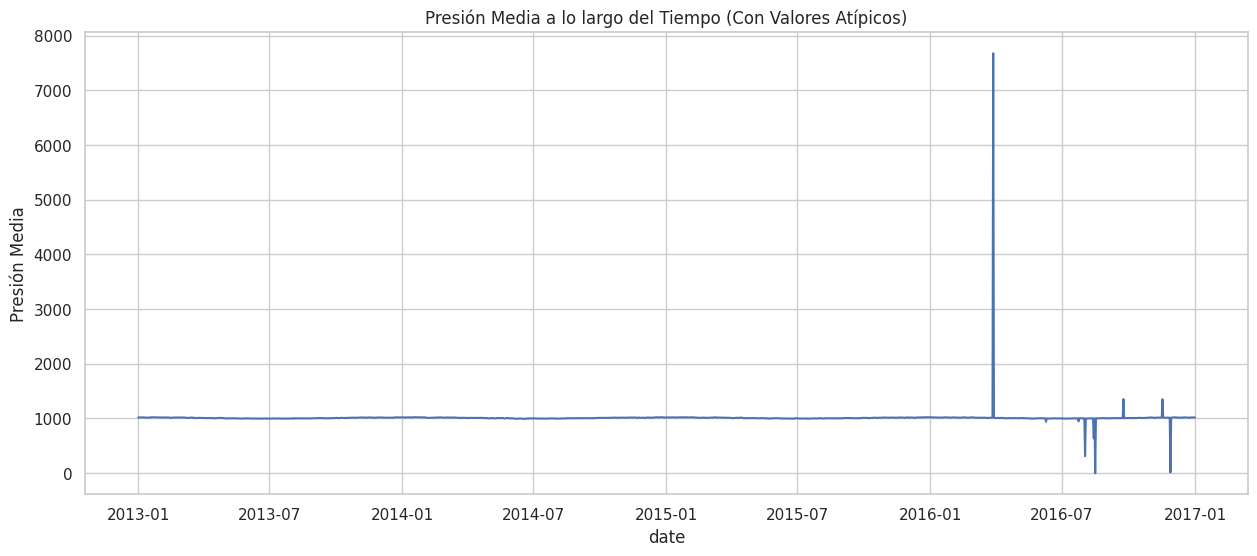

In [ ]:
# Gráfico con todos los datos (incluyendo valores atípicos)
plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='meanpressure', data=climate_data)
plt.title('Presión Media a lo largo del Tiempo (Con Valores Atípicos)')
plt.ylabel('Presión Media')
plt.show()

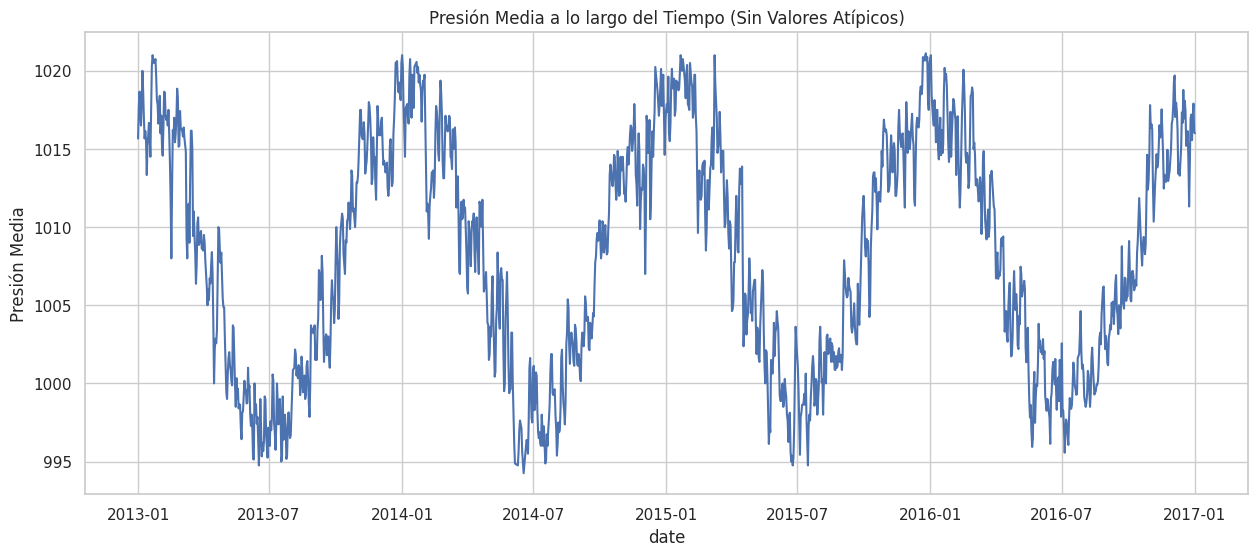

In [ ]:
pressure_min, pressure_max = climate_data['meanpressure'].quantile([0.01, 0.99])

# Filtrando los datos para excluir valores atípicos
filtered_data = climate_data[(climate_data['meanpressure'] > pressure_min) & (climate_data['meanpressure'] < pressure_max)]

# Creando un gráfico de serie temporal para la presión media después de excluir valores atípicos
plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='meanpressure', data=filtered_data)
plt.title('Presión Media a lo largo del Tiempo (Sin Valores Atípicos)')
plt.ylabel('Presión Media')
plt.show()

**Presión**: Al excluir los datos atipicos, vemos que la presion muestra un patrón mucho más regular y creible.

<ipython-input-16-2d58c6a8c70c>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = climate_data.corr()


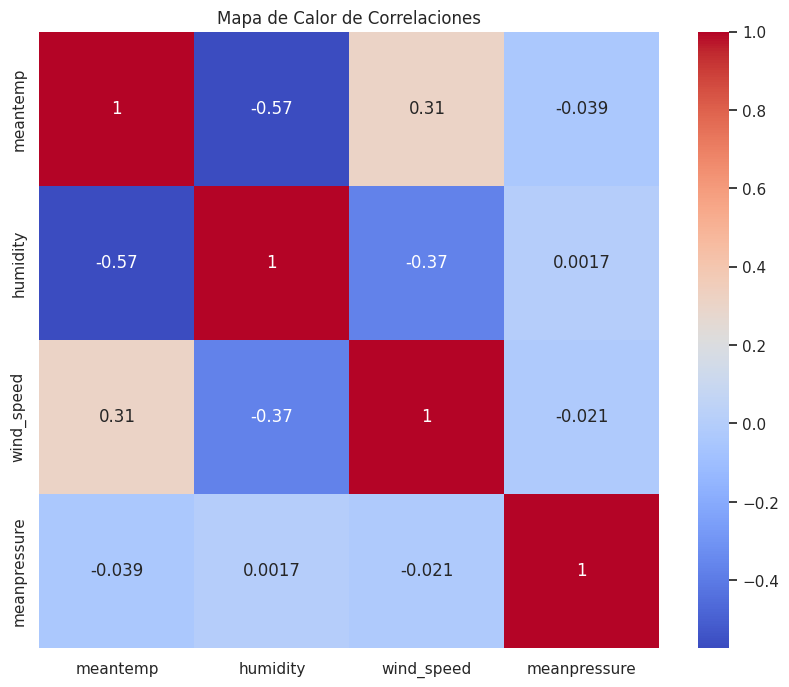

In [ ]:
# Calculando la matriz de correlación
correlation_matrix = climate_data.corr()

# Creando el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Mapa de Calor de Correlaciones')
plt.show()

La únicas correlaciones lineales que pasan el 0.5 son humedad y temperatura media, pero no es una correlacion exageradamente alta, como para pensar en utilizar PCA u alguna otra técnica de reduccion de dimensionalidad.

## 2.3 Preprocesamiento

En esta seccion deberan aplicar las transformaciones necesarias a los datos para poder entrenar su modelo, crear columnas, eliminar columnas, escalar los datos, etc.

In [ ]:
### Start Code Here ###
'''
Según lo visto en el análisis previo, vamos a eliminar los datos atípicos de la presión media
'''
# pressure_min, pressure_max = climate_data['meanpressure'].quantile([0.01, 0.99])
# train_df = climate_data[(climate_data['meanpressure'] > pressure_min) & (climate_data['meanpressure'] < pressure_max)].copy()
train_df.describe()
'''
Según lo conversado en clases hoy con el profe, decidimos dejar los outliers
'''


,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


In [ ]:
from sklearn.preprocessing import StandardScaler
# Funciones para convertir a coordenadas circulares
def encode_cyclical_feature(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

train_df['date'] = pd.to_datetime(train_df['date'])
# train_df['month'] = train_df['date'].dt.month
train_df['day_of_year'] = train_df['date'].dt.day_of_year

# train_df = encode_cyclical_feature(train_df, 'month', 12)
train_df = encode_cyclical_feature(train_df, 'day_of_year', 365)

train_df.drop('date', axis=1, inplace=True)
train_df.drop('day_of_year', axis=1, inplace=True)
# train_df.drop('month', axis=1, inplace=True)

objective_col = 'meantemp' # columna objetivo
selected_cols = ['humidity', 'wind_speed', 'meanpressure', 'day_of_year_sin','day_of_year_cos'] # columnas seleccionadas
# selected_cols = ['humidity', 'wind_speed', 'meanpressure', 'month_sin', 'month_cos'] # columnas seleccionadas
scaler = StandardScaler()
train_df[selected_cols] = scaler.fit_transform(train_df[selected_cols])


# Verificando las primeras filas para ver los datos normalizados
train_df.head()

,meantemp,humidity,wind_speed,meanpressure,day_of_year_sin,day_of_year_cos
0,10.000000,1.415439,-1.491699,0.025321,0.024327,1.411108
1,7.400000,1.862828,-0.838196,0.037162,0.048679,1.410480
2,7.166667,1.564569,-0.475626,0.041972,0.073018,1.409433
3,8.666667,0.630022,-1.221233,0.033647,0.097335,1.407968
4,6.000000,1.554627,-0.680303,0.029946,0.121622,1.406086


In [ ]:
# En este ejemplo nos quedamos solo con las columnas numericas, pero la idea es que en la lista anterior se incluyan las columnas que se quieran usar para entrenar el modelo, columnas nuevas que hayan creado o modificado en el preprocesamiento.
selected_cols = train_df.drop(columns=objective_col).select_dtypes(include='number').columns.tolist() # solo ejecutar a modo de ejemplo

In [ ]:
# IMPORTANTE: agregamos la columna objetivo al final de la lista, deben asegurarse de que este al final para el correcto funcionamiento del codigo
selected_cols.append(objective_col)
print(selected_cols)

['humidity', 'wind_speed', 'meanpressure', 'day_of_year_sin', 'day_of_year_cos', 'meantemp']


In [ ]:
# Realiza las mismas transformaciones en test_df
test_df['date'] = pd.to_datetime(test_df['date'])
# test_df['month'] = test_df['date'].dt.month
test_df['day_of_year'] = test_df['date'].dt.dayofyear

# test_df = encode_cyclical_feature(test_df, 'month', 12)
train_df = encode_cyclical_feature(test_df, 'day_of_year', 365)

test_df.drop('date', axis=1, inplace=True)
test_df.drop('day_of_year', axis=1, inplace=True)
# test_df.drop('month', axis=1, inplace=True)

tr_timeseries = train_df[selected_cols].values.astype('float32')
te_timeseries = test_df[selected_cols].values.astype('float32')

In [ ]:
# concatenamos los dataframes para despues hacer las visualizaciones, No borrar ni modificar
new = pd.concat([train_df, test_df], axis=0).reset_index().drop('index', axis=1)
new_timeseries = new[selected_cols].values.astype('float32')
shape = new_timeseries.shape[1]

## 2.4 Dataset y DataLoader

In [ ]:
def create_dataset(dataset, lookback, shape):
    """Funcion para crear los tensores de entrenamiento y test
    dataset: np.ndarray
    lookback: int (numero de dias a considerar o largo de la secuencia)
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[:,:shape-1][i:i+lookback]
        target = dataset[:, shape-1][i:i+lookback]
        X.append(feature)
        y.append(target)
    # Convierte las listas a np.ndarray antes de convertirlas en tensores
    X = np.array(X)
    y = np.array(y)
    return torch.tensor(X), torch.tensor(y)

In [ ]:
lookback = 7 #consideraremos los ultimos 7 dias para predecir el dia siguiente

train, test = tr_timeseries, te_timeseries
X_train, y_train = create_dataset(train, lookback=lookback, shape=shape)
X_test, y_test = create_dataset(test, lookback=lookback, shape=shape)

In [ ]:
loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size = 8, shuffle = True) #dataloader para entrenar los modelos de Pytorch

## 2.5 Modelo Recurrente

En esta seccion se implementa uan clase base para modelos recurrentes, pueden utilizar esta clase o pueden modificarla o crear una nueva clase si lo desean, recuerden que hay bonus por creatividad en esta tarea.

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, bidirectional, rnn_class):
        super().__init__()
        # Verificar que rnn_class es una de las clases de RNN permitidas
        if rnn_class not in [nn.LSTM, nn.GRU, nn.RNN]:
            raise ValueError("rnn_class must be nn.LSTM, nn.GRU, or nn.RNN")

        # Inicializar la capa recurrente con la clase pasada como parámetro
        self.rnn = rnn_class(input_size=input_size,
                             hidden_size=hidden_size,
                             num_layers=num_layers,
                             batch_first=True,
                             bidirectional=bidirectional)

        # Calcular la dimensión de salida de la capa recurrente
        # Es doble si es bidireccional
        factor = 2 if bidirectional else 1

        self.dropout = nn.Dropout(dropout)
        self.linear1 = nn.Linear(hidden_size * factor, 64)
        self.linear2 = nn.Linear(64, 64)
        self.output_linear = nn.Linear(64, 1)

    def forward(self, x):
        # LSTM devuelve (output, (h_n, c_n)) mientras que GRU y RNN solo devuelve (output, h_n)
        x, _ = self.rnn(x)
        x = self.dropout(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.output_linear(x)
        return x

## 2.6 Hiperparámetros

Aca pueden variar los hiperparametros de la red recurrente, pueden agregar mas si lo desean, para mas informacion sobre los optimizadores pueden revisar la documentacion de [pytorch Optim](https://pytorch.org/docs/stable/optim.html), y para mas informacion sobre los criterios de perdida pueden revisar la documentacion de [pytorch Loss](https://pytorch.org/docs/stable/nn.html#loss-functions)

In [ ]:
# Hiperparámetros del modelo
input_size = shape - 1
hidden_size = 2048
num_layers = 2
dropout = 0.15
bidirectional = True
layer_type = nn.GRU

# Definición del Modelo
model = RNNModel(input_size, hidden_size, num_layers, dropout, bidirectional, layer_type)

# Optimizador
lr = 0.001
optimizer = optim.AdamW(model.parameters(), lr=lr)

# Función de pérdida: MSE para regresión
loss_fn = nn.MSELoss()

## 2.7 Funciones de entrenamiento y evaluacion

En esta seccion se implementan funciones que nos ayudaran a entrenar y evaluar nuestro modelo, Pytorch no implementa metodos como .fit() por ende los tenemos que crear desde cero, al igual que antes sientanse libres de modificar o crear nuevas funciones, para mas informacion sobre el training loop pueden revisar la documentacion de [pytorch Custom Training](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#custom-training-loop)

In [ ]:
class CustomEarlyStopping:
    """
    Funcion para detener el entrenamiento cuando la loss de validacion no mejora
    """
    def __init__(self, patience=20, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_state = None
        self.best_y_pred = None

    def __call__(self, val_loss, model, X):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_state = model.state_dict()
            with torch.no_grad():
                self.best_y_pred = model(X)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}, score: {self.best_score}')

            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_state = model.state_dict()
            with torch.no_grad():
                self.best_y_pred = model(X)
            self.counter = 0

In [ ]:
def train_model(model, optimizer, early_stopping):
    """
    Funcion para entrenar el modelo
    """
    best_score = None
    best_weights = None

    n_epochs = 200

    for epoch in range(n_epochs):
        model.train() # Entrenamiento
        for X_batch, y_batch in loader:
            optimizer.zero_grad()  # Poner a cero los gradientes
            y_pred = model(X_batch)  # Forward pass
            y_pred = y_pred.squeeze(-1)
            loss = loss_fn(y_pred, y_batch)  # Calcular la pérdida
            loss.backward()  # Backward pass
            optimizer.step()  # Actualizar los pesos

        model.eval() # Validacion
        with torch.no_grad():
            y_pred = model(X_train)
            train_rmse = np.sqrt(loss_fn(y_pred, y_train.unsqueeze(2)))

            y_pred = model(X_test)
            test_rmse = np.sqrt(loss_fn(y_pred, y_test.unsqueeze(2)))

            if best_score is None or test_rmse < best_score:
                best_score = test_rmse
                best_weights = model.state_dict()

            early_stopping(test_rmse, model, X_test)

            # Check if early stopping criterion is met
            if early_stopping.early_stop:
                print("Early stopping")
                break

        if epoch % 10 == 0:
            print('*'*10, 'Epoch: ', epoch, '\ train RMSE: ', train_rmse, '\ test RMSE', test_rmse)

    return model, best_weights

In [ ]:
def get_preds(model, best_weights):
    """
    Funcion para obtener las predicciones y desnormalizarlas
    """
    # Usamos los mejores pesos para hacer las predicciones
    if best_weights is not None:
        model.load_state_dict(best_weights)

        # Calculamos las predicciones
        with torch.no_grad():
            y_pred_train = model(X_train).clone().detach().cpu().numpy()
            y_pred_test = model(X_test).clone().detach().cpu().numpy()

        # Modificamos las dimensiones de las predicciones para luego graficarlas
        with torch.no_grad():
            train_predictions = np.ones_like(new_timeseries) * np.nan
            train_predictions[lookback: len(train)] = y_pred_train[:,-1,:]

            test_predictions = np.ones_like(new_timeseries) * np.nan
            test_predictions[len(train)+lookback:len(new_timeseries)] = y_pred_test[:,-1,:]

        return train_predictions, test_predictions

In [ ]:
def plot_predictions(train_predictions, test_predictions, shape):
    """
    Funcion para graficar las predicciones
    """
    # plot
    plt.figure(figsize=(20,10))
    plt.plot(new_timeseries[:,shape-1], c = 'b', label = 'True')
    plt.plot(train_predictions[:,shape-1], c='r', label = 'Train')
    plt.plot(test_predictions[:,shape-1], c='g', label = 'Test')
    plt.legend()
    plt.show()

In [ ]:
def plot_eval(test_predictions, shape):
    """
    Funcion para graficar las predicciones
    """

    eval_df = pd.concat([test_df['meantemp'].reset_index(),pd.Series(test_predictions[:,shape-1][len(train):].reshape(-1).tolist())],axis=1).drop('index',axis=1) #creamos un dataframe con las predicciones y los valores reales

    eval_df.columns = ['real_meantemp', 'pred_meantemp'] #renombramos las columnas

    rmse = np.sqrt(mean_squared_error(eval_df.iloc[7:]['real_meantemp'], eval_df.iloc[7:]['pred_meantemp'])) #calculamos el rmse

    print(f'RMSE: {rmse}')

    fig = go.Figure(data = [
        go.Scatter(x = eval_df.index, y = eval_df['real_meantemp'], mode='lines', name = "Actual"),
        go.Scatter(x = eval_df.index, y = eval_df['pred_meantemp'], mode='lines', name="Predicted"),
    ])

    fig.update_layout(
        font = dict(size=17, family="Franklin Gothic"),
        template = 'simple_white',
        title = 'Real & Predicted Temperature'
    )

    fig.show()

## 2.8 Entrenamiento

In [ ]:
early_stopping = CustomEarlyStopping(patience=15, verbose=True)
model, model_best_weights = train_model(model, optimizer, early_stopping)

********** Epoch:  0 \ train RMSE:  tensor(6.9985) \ test RMSE tensor(6.9985)
EarlyStopping counter: 1 out of 15, score: -6.103076934814453
EarlyStopping counter: 2 out of 15, score: -6.103076934814453
EarlyStopping counter: 3 out of 15, score: -6.103076934814453
EarlyStopping counter: 4 out of 15, score: -6.103076934814453
EarlyStopping counter: 5 out of 15, score: -6.103076934814453
EarlyStopping counter: 6 out of 15, score: -6.103076934814453
EarlyStopping counter: 7 out of 15, score: -6.103076934814453
EarlyStopping counter: 8 out of 15, score: -6.103076934814453
EarlyStopping counter: 9 out of 15, score: -6.103076934814453
********** Epoch:  10 \ train RMSE:  tensor(6.4612) \ test RMSE tensor(6.4612)
EarlyStopping counter: 10 out of 15, score: -6.103076934814453
EarlyStopping counter: 11 out of 15, score: -6.103076934814453
EarlyStopping counter: 12 out of 15, score: -6.103076934814453
EarlyStopping counter: 1 out of 15, score: -6.101030349731445
EarlyStopping counter: 2 out of 15

In [ ]:
train_predictions, test_predictions = get_preds(model, model_best_weights)

In [ ]:
train_df.shape

(1432, 6)

## 2.9 Evaluacion

In [ ]:
plot_eval(test_predictions, (6))

RMSE: 3.0490501449517424


# Parte 3: Transformers

Para esta parte vamos a entrenar un transformer muy simple para que aprenda a generar texto como el del Quijote.

### 3.1 Cargar el dataset

In [ ]:
with open('data/el_quijote.txt', 'r', encoding='utf-8') as f:
    text = f.read()

FileNotFoundError: ignored

In [ ]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1038397


In [ ]:
# Visualizamos los primeros 1000 caracteres
print(text[:1000])

DON QUIJOTE DE LA MANCHA
Miguel de Cervantes Saavedra

PRIMERA PARTE
CAPÍTULO 1: Que trata de la condición y ejercicio del famoso hidalgo D. Quijote de la Mancha
En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua, rocín flaco y galgo corredor. Una olla de algo más vaca que carnero, salpicón las más noches, duelos y quebrantos los sábados, lentejas los viernes, algún palomino de añadidura los domingos, consumían las tres partes de su hacienda. El resto della concluían sayo de velarte, calzas de velludo para las fiestas con sus pantuflos de lo mismo, los días de entre semana se honraba con su vellori de lo más fino. Tenía en su casa una ama que pasaba de los cuarenta, y una sobrina que no llegaba a los veinte, y un mozo de campo y plaza, que así ensillaba el rocín como tomaba la podadera. Frisaba la edad de nuestro hidalgo con los cincuenta años, era de complexión recia, sec

### 3.2 Preprocesar el dataset

Vamos a crear un tokenizador muy simple que convierta el texto en una secuencia de números.

In [ ]:
chars = set(text) # Para obtener los caracteres únicos en el texto
vocab_size = len(chars)
print('Caracteres unicos:',''.join(chars))
print('Largo del vocabulario:',vocab_size)

Caracteres unicos: »̃qzJ‘.LOacvgrD"«¡8o4̀muPR1:e“I?U3̈Ny!B'”Eb0dSQXl
́HM¿9;5Fp Vh<CiYftn7[Zx(W-TjKs)6A],’G–2
Largo del vocabulario: 89


### 3.3 Encoding y Decoding

Ahora que tenemos el tokenizador, vamos a crear una función que nos permita convertir el texto en una secuencia de números y viceversa.

In [ ]:
# Mapeamos cada caracter a un entero
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: toma un string, devuelve una lista de enteros
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: toma una lista de enteros, devuelve un string

print(encode("Quijote de la Mancha"))
print(decode(encode("Quijote de la Mancha")))

[46, 23, 64, 77, 19, 67, 28, 59, 44, 28, 59, 48, 9, 59, 52, 9, 68, 10, 61, 9]
Quijote de la Mancha


**pregunta: Que otros tipos de tokenizaciones ademas de por caracteres existen y cuales serian las ventajas?**

***Respuesta***: Es posible usar tokenización por palabras, frases o párrafos. Las principales ventajas son que los tokens de palabras pueden ser utilizados como sinónimos, mientras que para la tokenización de párrafos se puede ver el contexto en el que se utilizan las palabras.

**Pregunta: ¿que otras tecnicas se utilizan antes de tokenizar en problemas de NLP?**

***Respuesta***: Antes de la tokenización, se suele filtrar algunas caracteres especiales para que sean separadas de algunas letras. Por ejemplo, algunas palabras pueden quedar con un signo de interrogación, lo que no siempre es útil para la tokenización, por lo que se deben eliminar tales caracteres. Otras técnicas usadas son la lematización y la derivación, ambas para simplificar palabras.

### 3.4 Train y Val Split

In [ ]:
# Vamos a Codificar el texto y llevarlo a un tensor de Pytorch
data = torch.tensor(encode(text), dtype=torch.long)

# Separamos en train y validation
n = int(0.5*len(text)) # % de los datos para entrenar
train_data = data[:n]
val_data = data[n:]

print(train_data.shape, train_data.dtype)
print(train_data[:1000]) # los primeros 1000 caracteres del texto codificado

torch.Size([519198]) torch.int64
tensor([14,  8, 35, 59, 46, 32, 30,  4,  8, 76, 41, 59, 14, 41, 59,  7, 82, 59,
        52, 82, 35, 63, 51, 82, 49, 52, 64, 12, 23, 28, 48, 59, 44, 28, 59, 63,
        28, 13, 11,  9, 68, 67, 28, 79, 59, 45,  9,  9, 11, 28, 44, 13,  9, 49,
        49, 24, 25, 30, 52, 41, 25, 82, 59, 24, 82, 25, 76, 41, 49, 63, 82, 24,
        30, 50, 76, 32,  7,  8, 59, 26, 27, 59, 46, 23, 28, 59, 67, 13,  9, 67,
         9, 59, 44, 28, 59, 48,  9, 59, 10, 19, 68, 44, 64, 10, 64, 19, 50, 68,
        59, 36, 59, 28, 77, 28, 13, 10, 64, 10, 64, 19, 59, 44, 28, 48, 59, 66,
         9, 22, 19, 79, 19, 59, 61, 64, 44,  9, 48, 12, 19, 59, 14,  6, 59, 46,
        23, 64, 77, 19, 67, 28, 59, 44, 28, 59, 48,  9, 59, 52,  9, 68, 10, 61,
         9, 49, 41, 68, 59, 23, 68, 59, 48, 23, 12,  9, 13, 59, 44, 28, 59, 48,
         9, 59, 52,  9, 68, 10, 61,  9, 84, 59, 44, 28, 59, 10, 23, 36, 19, 59,
        68, 19, 22, 42, 13, 28, 59, 68, 19, 59,  2, 23, 64, 28, 13, 19, 59,  9,
       

### 3.5 Generando sequencias de texto

El transformer es una arquitectura de secuencias, por lo que necesitamos generar las secuencias de texto que vamos a utilizar para entrenar el modelo.

In [ ]:
batch_size = 4 # cuantas secuencias de texto vamos a procesar en paralelo
block_size = 8 # definimos el largo de nuestra sequencia

def get_batch(split):
    # generamos un batch de datos
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [ ]:
xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"cuando el input es {context} el target es: {target}")

inputs:
torch.Size([4, 8])
tensor([[ 1, 62, 52, 69,  1, 61, 65, 68],
        [ 1, 42, 52, 64, 54, 59, 65,  1],
        [56,  1, 59, 52, 53, 60, 81, 52],
        [68,  1, 70, 52, 64,  1, 63, 71]])
targets:
torch.Size([4, 8])
tensor([[62, 52, 69,  1, 61, 65, 68, 64],
        [42, 52, 64, 54, 59, 65,  1, 67],
        [ 1, 59, 52, 53, 60, 81, 52,  1],
        [ 1, 70, 52, 64,  1, 63, 71, 54]])
----
cuando el input es tensor([1]) el target es: 62
cuando el input es tensor([ 1, 62]) el target es: 52
cuando el input es tensor([ 1, 62, 52]) el target es: 69
cuando el input es tensor([ 1, 62, 52, 69]) el target es: 1
cuando el input es tensor([ 1, 62, 52, 69,  1]) el target es: 61
cuando el input es tensor([ 1, 62, 52, 69,  1, 61]) el target es: 65
cuando el input es tensor([ 1, 62, 52, 69,  1, 61, 65]) el target es: 68
cuando el input es tensor([ 1, 62, 52, 69,  1, 61, 65, 68]) el target es: 64
cuando el input es tensor([1]) el target es: 42
cuando el input es tensor([ 1, 42]) el target es: 52

### 3.6 Creando el modelo

Vamos a crear un modelo naive que consiste en una capa de embedding, y una capa de salida que predice la siguiente palabra

In [ ]:
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # cada token se representa como un vector de vocab_size dimensiones
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx y targets son (B, T) arrays de indices en el vocabulario
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

**Pregunta: Explique que hace la funcion Generate (indicar que hace cada linea de la funcion)**

***Respuesta***:
* Línea 1: for que se detiene hasta llegar llegar hasta el número máximo de tokens establecido
* Línea 2: se obtienen los logits, que corresponden a las salidas antes de aplicar la función softmax, y se obtiene la pérdida asociada antes de realizar la función.
* Línea 3: el algoritmo se queda con el último valor de logits, esto es para predecir el siguiente valor.
* Línea 4: se obtienen probabilidades normalizadas. Utiliza el valor conseguido anteriormente. Se realiza la función Softmax, la cual equivale a $\frac{exp(x_i)}{\sum_{j}{exp(x_j)} }$
* Línea 5: torch.multinomial retorna una sola fila con lo obtenido en la distribución multinomial.
* Línea 6: se concatenan idx con idx_net.
* Línea 7: retorna la secuencia completa de tokens generados.

In [ ]:
# Hiperparametros
naive_model = BigramLanguageModel(vocab_size)
optimizer = optim.Adam(naive_model.parameters(), lr=0.001)
batch_size = 16
epochs = 50

loss_fn = torch.nn.CrossEntropyLoss()  # binary cross entropy

En esta seccion deberan crear un loop de entrenamiento para esto pueden revisar la documentacion de [Pytorch](https://pytorch.org/docs/stable/index.html)

In [ ]:
# Entrenamiento

for i in range(epochs):
    # obtenemos un batch de datos
    Xbatch = train_data[i:i+batch_size]
    Ybatch = val_data[i:i+batch_size]

    # Obtenemos las predicciones del modelo y la loss
    y_pred = naive_model(Xbatch)[0]
    loss =  loss_fn(y_pred, Ybatch)

    # reseteamos el gradiente
    optimizer.zero_grad()

    # Backward Pass
    loss.backward()

    # Actualizamos los pesos
    optimizer.step()

    # Visualizamos el resultado cada 10 iteraciones
    if i % 10 == 0:
        print(f"Epoch {i} | Loss {loss.item():.4f}")

Epoch 0 | Loss 5.0353
Epoch 10 | Loss 5.0066
Epoch 20 | Loss 4.9951
Epoch 30 | Loss 4.9283
Epoch 40 | Loss 4.9283
Epoch 50 | Loss 5.0092
Epoch 60 | Loss 4.8959
Epoch 70 | Loss 4.8777
Epoch 80 | Loss 4.8310
Epoch 90 | Loss 4.9345


In [ ]:
print('loss:', loss.item())
print(decode(naive_model.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

loss: 4.777909278869629

8s4““,T[W»6'e(u¿T¡hvM<z?WZzEB̀XRqBiMV¿»n,;OTśt‘I“<GKz,fV[o<i-uoH8«‘“"”
–zEḦ[XI(Asx‘H3BHJVbTA»Rv«»0


Como vemos el modelo no es capaaz de generar texto coherente, para esto vamos a utilizar un transformer.

### 3.7 Transformer

El transformer es una arquitectura de secuencias que utiliza atención para poder capturar dependencias de largo plazo, en esta seccion deberan completar las lineas de codigo faltantes, para esto pueden revisar el paper originar [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf) y la documentacion de [Pytorch](https://pytorch.org/docs/stable/index.html)

In [ ]:
n_embd = 512 # dimension de los embeddings
n_head = 8 # numero de cabezas de atencion
n_layer = 6 # numero de capas
dropout = 0.1 # dropout

In [ ]:
class Head(nn.Module):
    """ cabezal de auto-atencion """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(head_size, head_size)
        self.query = nn.Linear(head_size, head_size)
        self.value = nn.Linear(head_size, head_size)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)

        # Calcula la matriz de pesos (Afinidades)
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        softmax = F.softmax(wei, dim=1)
        dropout = self.dropout(softmax)

        # Calcula la ponderacion de los valores por los pesos atencionales
        v = self.value(x)
        out = softmax @ v  # (B, T, T) @ (B, T, C) -> (B, T, C)

        return out

**Pregunta: En sus propias palabras explique como funciona el mecanismo de auto-atencion**

***Respuesta***: primero se debe tomar el input que se quiere leer, el cual puede ser un texto a traducir. Luego se crean los pesos a partir del input, los cuales son las *keys*, las *query* y los *values*. Con tales valores se calculan los *scores* o puntajes, donde el $Puntaje_{ij}$ es el puntaje entre la *query* $i$ y la *key* $j$. Por último, se calcula la ponderación de los valores totales.

In [ ]:
class MultiHeadAttention(nn.Module):
    """ Multiples cabezales de auto-atencion """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [ ]:
class FeedFoward(nn.Module):
    """ Capa FeedForward """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 2),
            nn.Sigmoid(),
            nn.Linear(2, 4),
            nn.Softmax()
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class Block(nn.Module):
    """ Bloque de Transformer """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

**Pregunta: Que parte del transformer estamos implementando?**

***Respuesta***: Se está implementado el encoder, esto es principalmente porque no se realiza un *Masked Multi-Head Attention*; esto equivale a la primer etapa del transformer, para que luego el resultado del encoder sea utilizado en el decoder.

In [ ]:
# Ahora definimos el modelo completo con los bloques de Transformer
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :] # (B, C)
            probs = F.softmax(logits, dim=-1) # (B, C)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

**Bonus: Desde que salio el transformer se han publicado mejoras para esta arquitectura, si implementan alguna mejora con la referencia del paper en cuestion obtendran un bonus, se atreven?**

In [ ]:
model = BigramLanguageModel()
m = model.to(device)

# Parametros del modelo
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# Hiperparametros
lr = 0.001 # Tasa de aprendizaje
optimizer = torch.optim.Adam(m.parameters(), lr=lr)  # Optimizador (Adam en este caso)
epochs = 10
eval_interval = 100
eval_iters = 200

NameError: ignored

In [ ]:
# Funcion de evaluar el modelo
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [ ]:
for i in range(epochs):
    # cada 100 iteraciones evaluamos el modelo
    if i % eval_interval == 0 or i == epochs - 1:
        losses = estimate_loss()
        print(f"step {i}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # Obtenemos un batch de datos
    #TODO

    # Obtener las predicciones del modelo y la loss
    #TODO

    # reseteamos el gradiente
    #TODO

    # Backward Pass
    #TODO

    # Actualizamos los pesos
    #TODO

In [ ]:
# Generamos las predicciones
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


Eleil brados abía, éstaba acirdumas de me su pestí su que se ni pues, al forde una lariencabal curo; y alí se valvade que aalgántilo"
-Nespondió de su mandado de la recida. Perotres sagraso, y porque al los vida en el ningón con el las ha galar enfamala razon y las punto de acaseravan que respareo no de casas,tora de dé duda sin,  fue hasto de apenaba por todos Dioso Esten cama le soltión, y padros nos vuestro que sillestro y ellar de haced que que pe dijo Recho cual entura y la otras y Zoraño adelligatir due a barpes corrás as encamigarosu el malgas casilla osufa;, si comelsar compenio, y aún luello, a tantodo mate aun eruente, dondespecha elles niención mazo, selevatendo cierda; y tinienced mala ibonse de lo hecermas, las raza volvente por que él hubiero tierna, inteñoreso despeseju acomola dijo por adren del rálipa permadar El me las cuitros casasn de cuallabo señora, por ahedo dan tomanar alecigo, y estro; o su adía, venía quede ser engu, la sianque siemigeza, y

Ahora las predicciones ya tienen un poco de sentido, podemos seguir entrenando el modelo para que genere texto más coherente y pueden utilizar el modelo cambiando el archivo de input para generar texto de otros libros o de lo que ustedes quieran.

# Bonus: Armonic Oscillator (PINN)

## Simular un oscilador armónico

Vamos a utilizar una red neuronal con física incorporada (PINN por sus siglas en inglés) para resolver problemas relacionados con el **oscilador armónico amortiguado**:

<img src="img/oscillator.gif" width="500">

Nos interesa modelar el desplazamiento de la masa en un resorte (caja verde) a lo largo del tiempo.

Este es un problema canónico de la física, donde el desplazamiento, $u(t)$, del oscilador como función del tiempo puede ser descrito por la siguiente ecuación diferencial:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

donde $ m $ es la masa del oscilador, $ \mu $ es el coeficiente de fricción y $ k $ es la constante del resorte.

Nos centraremos en resolver el problema en el estado **subamortiguado**, es decir, donde la oscilación es lentamente amortiguada por la fricción (como se muestra en la animación arriba).

Matemáticamente, esto ocurre cuando:

$$
\delta < \omega_0~,~~~~~\mathrm{donde}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

Además, consideramos las siguientes condiciones iniciales del sistema:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

Para este caso particular, la solución exacta es conocida y dada por:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{con}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$


### Definimos nuestra Red Neuronal

In [ ]:
class simple_ffn(nn.Module):
    "Definimos una red neuronal feed forward en PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.input = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.hidden = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.output = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.input(x)
        x = self.hidden(x)
        x = self.output(x)
        return x

*Pregunta: ¿Porque se utiliza Tanh como función de activación generalmente en las PINNs?*

###  Solucion Exacta

In [ ]:
def exact_solution(d, w0, t):
    "Define la solucion analitica del problema planteado"
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

### Puntos de entrenamiento

In [ ]:
# Definimos los puntos para la condicion de borde
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# Definimos los puntos del dominio del problema
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# parametros del problema
d, w0 = 2, 20
mu, k = 2*d, w0**2

# Solucion Exacta para comparar con el resultado de la red neuronal
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

### Hiperparámetros y Modelo

In [ ]:
epochs = 15001
pinn = simple_ffn(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=3)
optim = torch.optim.Adam(pinn.parameters(),lr=1e-3)
lambda1, lambda2 = 1e-1, 1e-4

### Entrenamiento

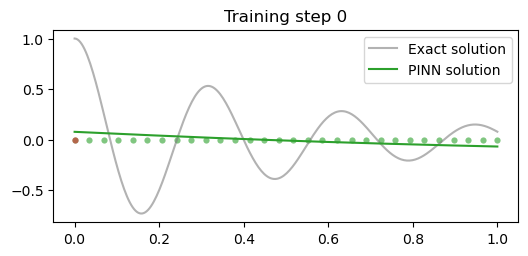

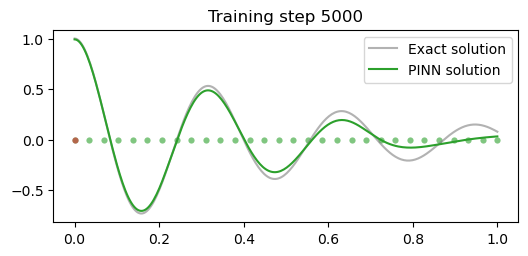

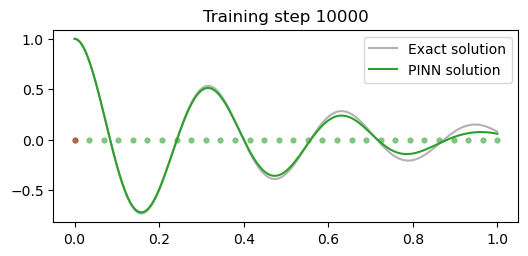

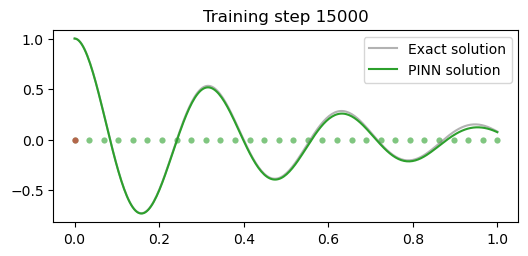

In [ ]:
for i in range(15001):
    optim.zero_grad() # reseteamos el gradiente

    # Calculamos la perdida de la condicion de borde
    u = pinn(t_boundary)
    loss1 = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0] # calculamos la derivada
    loss2 = (torch.squeeze(dudt) - 0)**2

    # Calculamos la perdida de la ecuacion diferencial
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0] # calculamos la derivada
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0] # calculamos la segunda derivada
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # Calculamos la perdida total (Custom Loss)
    loss = loss1 + lambda1*loss2 + lambda2*loss3

    # Backward Pass
    loss.backward()

    # Actualizamos los pesos
    optim.step()

    # Visualizamos el resultado cada 5000 iteraciones
    if i % 5000 == 0:
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

## entrenar una PINN para invertir los parámetros subyacentes

La segunda tarea consiste en usar una PINN para **Estimar** parámetros.

Específicamente, nuestras entradas y salidas son:

- Entradas: observaciones con ruido del desplazamiento del oscilador
- Salidas: estimar $\mu$, el coeficiente de fricción

#### Enfoque

De manera similar a lo anterior, la PINN se entrena para aproximar directamente la solución a la ecuación diferencial, es decir

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

donde $\theta$ son los parámetros libres de la PINN.

La idea clave aquí es también tratar $\mu$ como un **parámetro aprendible** al entrenar la PINN, de modo que simulamos la solución e invertimos para este parámetro.

#### Función de pérdida

La PINN se entrena con una función de pérdida ligeramente diferente:

$$
\mathcal{L}(\theta, \mu)= \frac{1}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2 + \frac{\lambda}{M} \sum^{M}_{j} \left( u_{\mathrm{PINN}}(t_{j};\theta) - u_{\mathrm{obs}}(t_{j}) \right)^2
$$

#### Notas

Hay dos términos en la función de pérdida aquí. El primero es la **pérdida física**, formada de la misma manera que arriba, que asegura que la solución aprendida por la PINN es consistente con la física conocida.

El segundo término se llama **pérdida de datos**, y asegura que la solución aprendida por la PINN se ajuste a las observaciones de la solución (potencialmente con ruido) que están disponibles.

Nota, hemos eliminado los términos de pérdida de los bordes, ya que no los conocemos (es decir, solo se nos dan las mediciones observadas del sistema).

En esta configuración, los parámetros $\theta$ y $\mu$ de la PINN se aprenden **conjuntamente** durante la optimización.

Nuevamente, la autodiferenciación es nuestra amiga y nos permitirá definir fácilmente este problema.


### Puntos de Entrenamiento

True value of mu: 4


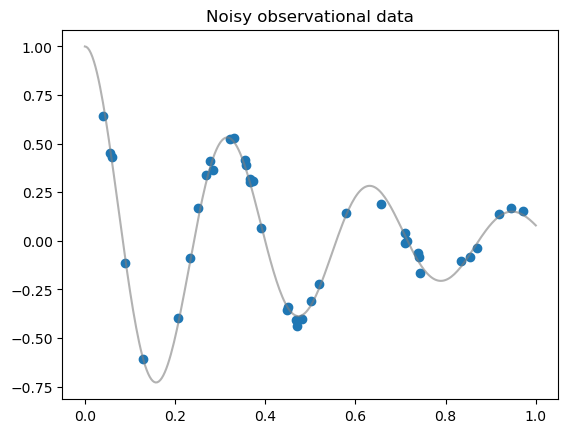

In [ ]:
# Creamos data con ruido
d, w0 = 2, 20
print(f"True value of mu: {2*d}")

# Definimos los puntos observacionales para que la red aprenda de los datos
t_obs = #TODO
u_obs = exact_solution(d, w0, t_obs) + 0.04*torch.randn_like(t_obs)

# definimos los puntos de entrenamiento sobre todo el dominio para la loss de la ecuacion diferencial
t_physics = #TODO

# parametros del problema
_, k = 2*d, w0**2

plt.figure()
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0])
t_test, u_exact = torch.linspace(0,1,300).view(-1,1), exact_solution(d, w0, t_test)
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.show()

### Hiperparámetros y Modelo

In [ ]:
# Creamos un parametro entrenable para mu
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
mus = []

epochs = #TODO
pinn = #TODO
optim = torch.optim.Adam(list(pinn.parameters())+[mu],lr=1e-3)
lambda1 = 1e4

### Entrenamiento

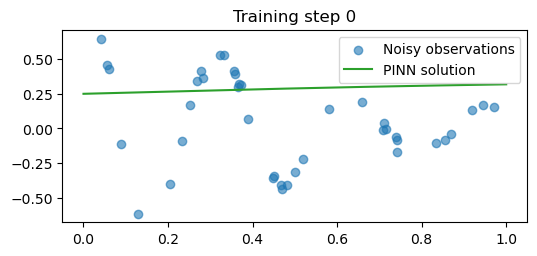

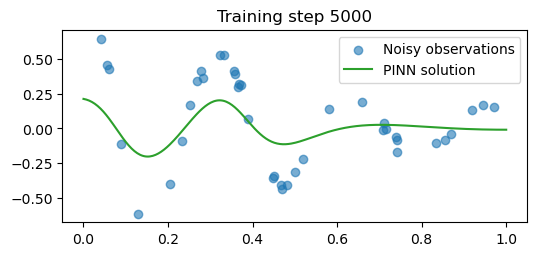

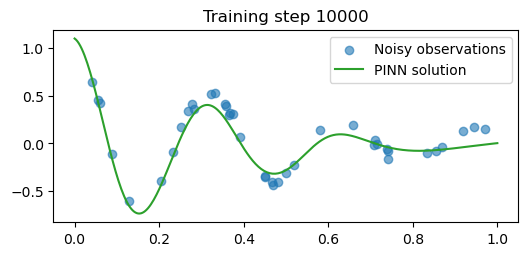

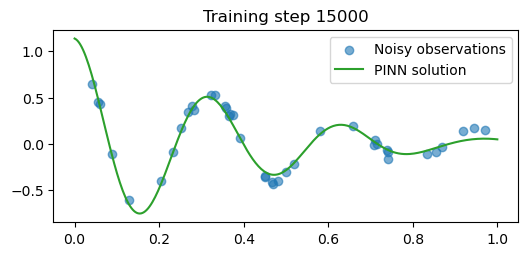

In [ ]:
for i in range(epochs):
    # reseteamos el gradiente
    #TODO

    # Calculamos la perdida de la ecuacion diferencial
    u = #TODO
    dudt = #TODO
    d2udt2 = #TODO
    loss1 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # Calculamos la perdida en funcion de los datos
    u = #TODO
    loss2 = torch.mean((u - u_obs)**2)

    # Calculamos la perdida total (Custom Loss)
    loss = loss1 + lambda1*loss2

    # Backward Pass
    #TODO

    # Actualizamos los pesos
    #TODO

    # guardamos el valor de mu
    mus.append(mu.item())

    # Visualizamos el resultado cada 5000 iteraciones
    if i % 5000 == 0:
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_obs[:,0], u_obs[:,0], label="Noisy observations", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

### Estimacion de $\mu$

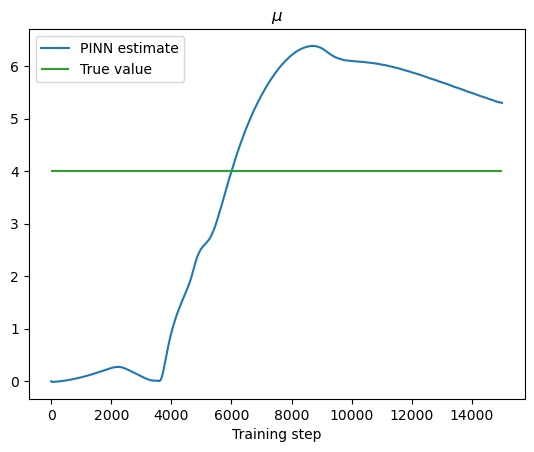

In [ ]:
plt.figure()
plt.title("$\mu$")
plt.plot(mus, label="PINN estimate")
plt.hlines(2*d, 0, len(mus), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

## cómo escala la PINN a oscilaciones de mayor frecuencia



La tarea final es investigar cómo escala la PINN a oscilaciones de mayor frecuencia y qué se puede hacer para mejorar su convergencia.

Específicamente, volvemos a simular la solución al oscilador armónico e incrementamos su frecuencia, $\omega_0$.


la PINN lucha para converger, incluso si el número de puntos de entrenamiento físico aumenta.

Este es un problema más difícil para la PINN de resolver, en parte debido al **sesgo espectral** de las redes neuronales, así como al hecho de que se requieren más puntos de entrenamiento.

#### Enfoque: formulación alternativa "ansatz"

Para acelerar la convergencia, una forma es **asumir algo** sobre la solución.

Por ejemplo, supongamos que sabemos por nuestra intuición física que la solución es de hecho sinusoidal.

Entonces, en lugar de tener la PINN aproximando directamente la solución a la ecuación diferencial, es decir

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

En su lugar, usamos la PINN como parte de un ansatz matemático de la solución, es decir

$$
\hat u(t; \theta, \alpha, \beta) = u_{\mathrm{PINN}}(t;\theta)  \sin (\alpha t + \beta) \approx u(t)~,
$$

donde $\alpha, \beta$ se tratan como parámetros adicionales aprendibles.

Comparando este ansatz con la solución exacta

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))
$$

Vemos que ahora la PINN solo necesita aprender la función exponencial, lo cual debería ser un problema mucho más fácil.

¡Una vez más, la autodiferenciación nos permite diferenciar fácilmente a través de este ansatz para entrenar la PINN!


### Puntos de Entrenamiento

In [ ]:
# Definimos los parametros A y B para la Ansatz
a = torch.nn.Parameter(70*torch.ones(1, requires_grad=True))
b = torch.nn.Parameter(torch.ones(1, requires_grad=True))

# Definimos los puntos de borde
t_boundary = #TODO

# Definimos los puntos de entrenamiento sobre todo el dominio para la loss de la ecuacion diferencial
t_physics = #TODO

# Parametros del problema
d, w0 = 2, 80 # las oscilaciones (w0) aumentaron
mu, k = 2*d, w0**2

# Solucion Exacta para comparar con el resultado de la red neuronal
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)


### Hiperparámetros y Modelo

In [ ]:
pinn = #TODO
optim = #TODO
lambda1, lambda2 = 1e-1, 1e-4

### Entrenamiento

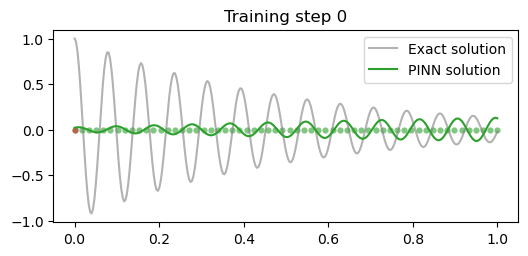

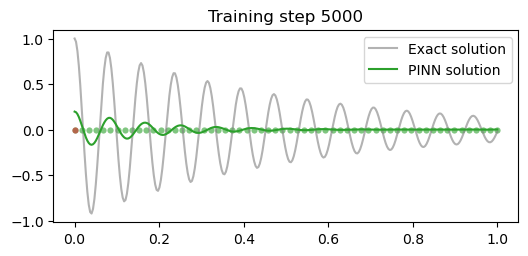

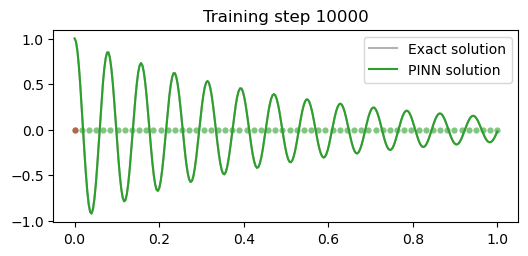

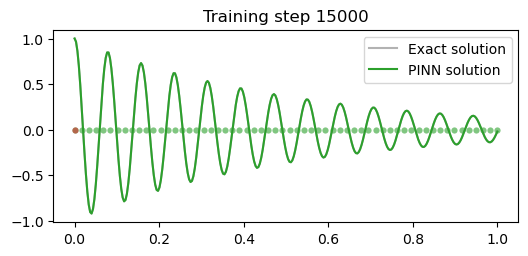

In [ ]:
for i in range(15001):
    # reseteamos el gradiente
    #TODO

    # Calculamos la perdida de la condicion de borde
    u = #TODO
    loss1 = #TODO
    dudt = #TODO
    loss2 = #TODO

    # Calculamos la perdida de la ecuacion diferencial
    u = #TODO
    dudt = #TODO
    d2udt2 = #TODO
    loss3 = #TODO

    # Calculamos la perdida total (Custom Loss)
    loss = loss1 + lambda1*loss2 + lambda2*loss3

    # Backward Pass
    #TODO

    # Actualizamos los pesos
    #TODO

    # Visualizamos el resultado cada 5000 iteraciones
    if i % 5000 == 0:
        u = (pinn(t_test)*torch.sin(a*t_test+b)).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()